In [1]:
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import Perceptron
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

RANDOM_STATE = 11
RS = np.random.RandomState(RANDOM_STATE)

## Load Features

In [24]:
train_ = np.load('output/train_features.npz')
val_ = np.load('output/val_features.npz')
test_ = np.load('output/test_features.npz')

train_X, train_y = train_['X'], train_['y']
val_X, val_y = val_['X'], val_['y']
test_X, test_y = test_['X'], test_['y']

In [25]:
print("{:<8} shape: ".format('train_X'), train_X.shape)
print("{:<8} shape: ".format('val_X'), val_X.shape)
print("{:<8} shape: ".format('test_X'), test_X.shape)

train_X  shape:  (63325, 1344)
val_X    shape:  (450, 1344)
test_X   shape:  (450, 1344)


## Build Model
<pre>
Choose at least three methods: Perceptron, Catboost, PyTorch-nn
Show the curves of accuracy in trainning and testing phase.
The predict result on the validation/testing phase. (top-1 accuracy and top-5 accuracy)
</pre>

### Toolbox

In [26]:
def calc_top5_acc(true_y, top5_y):
    ls_correct = [1 if true_y[i] in top5_y[i] else 0 for i in range(len(true_y))]
    return sum(ls_correct) / len(ls_correct)

def evaluate_score(true_y, pred_y_proba):
    pred_y = pred_y_proba.argmax(axis=1)
    top1_acc = round(accuracy_score(true_y, pred_y), 4)
    
    top5_y = np.argpartition(pred_y_proba, -5)[:, -5:]
    top5_acc = round(calc_top5_acc(true_y, top5_y), 4)
    return (top1_acc, top5_acc)

# evaluate_score(val_y, val_y_proba)

### Perceptron

In [5]:
per_clf = Perceptron(random_state=RANDOM_STATE, n_jobs=-1, shuffle=True)
per_clf.fit(train_X, train_y)
val_y_proba = per_clf.decision_function(val_X)

test_y_proba = per_clf.decision_function(test_X)

per_val_acc = evaluate_score(val_y, val_y_proba)
per_test_acc = evaluate_score(test_y, test_y_proba)

# top1_acc, top5_acc
print(per_val_acc)
print(per_test_acc)

(0.0422, 0.1822)
(0.0644, 0.1778)


### CatBoost

In [6]:
cat_clf = CatBoostClassifier(
    iterations=2000, early_stopping_rounds=50,
    random_state=RANDOM_STATE, verbose=50, use_best_model=True)
cat_clf.fit(train_X, train_y, eval_set=(val_X, val_y))
val_y_proba = cat_clf.predict_proba(val_X)
test_y_proba = cat_clf.predict_proba(test_X)

cat_val_acc = evaluate_score(val_y, val_y_proba)
cat_test_acc = evaluate_score(test_y, test_y_proba)

# top1_acc, top5_acc
print(cat_val_acc)
print(cat_test_acc)

# output 
# (0.2978, 0.6133)
# (0.28, 0.5822)

Learning rate set to 0.090026
0:	learn: 3.8669413	test: 3.8646928	best: 3.8646928 (0)	total: 1.17s	remaining: 39m 8s
50:	learn: 3.2296886	test: 3.3199633	best: 3.3199633 (50)	total: 52.6s	remaining: 33m 31s
100:	learn: 2.9906798	test: 3.1892998	best: 3.1892998 (100)	total: 1m 44s	remaining: 32m 46s
150:	learn: 2.7977880	test: 3.0834402	best: 3.0834402 (150)	total: 2m 35s	remaining: 31m 49s
200:	learn: 2.6626253	test: 3.0178248	best: 3.0178248 (200)	total: 3m 26s	remaining: 30m 50s
250:	learn: 2.5575288	test: 2.9692812	best: 2.9692812 (250)	total: 4m 17s	remaining: 29m 53s
300:	learn: 2.4693186	test: 2.9314698	best: 2.9314698 (300)	total: 5m 7s	remaining: 28m 57s
350:	learn: 2.4011097	test: 2.9044201	best: 2.9044201 (350)	total: 5m 58s	remaining: 28m 2s
400:	learn: 2.3449149	test: 2.8837260	best: 2.8836158 (399)	total: 6m 48s	remaining: 27m 9s
450:	learn: 2.2946713	test: 2.8650955	best: 2.8649896 (449)	total: 7m 39s	remaining: 26m 17s
500:	learn: 2.2556021	test: 2.8492118	best: 2.849211

In [7]:
cat_clf.save_model('best_model/cat_clf')

### Torch NN

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [28]:
class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(1344, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 50)
        )
    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_stack(x)
        pred_proba = nn.Softmax(dim=1)(logits)
        return logits

image_model = ImageModel().to(device)

lr = 1e-4
wd = 1e-5
batch_size = 512
epochs = 50

# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizers
optimizer = torch.optim.Adam(image_model.parameters(), lr=lr, weight_decay=wd)

In [29]:
# tensor
train_X = torch.from_numpy(train_X).to(torch.float32)
train_y = torch.from_numpy(train_y)

val_X = torch.from_numpy(val_X).to(torch.float32)
val_y = torch.from_numpy(val_y)

test_X = torch.from_numpy(test_X).to(torch.float32)
test_y = torch.from_numpy(test_y)

# dataset
train_dataset = TensorDataset(train_X, train_y)
val_dataset = TensorDataset(val_X, val_y)
test_dataset = TensorDataset(test_X, test_y)

# dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [30]:
# training loop
def train_loop(epochs, model, loss_fn, optimizer, train_loader, val_loader=None):
    global device
    ls_loss = []
    ls_acc = []
    ls_val_loss = []
    ls_val_acc = []
    dict_best = {'epoch': -1, 'best_val_loss': 1e10}
    
    model.train()
    for i in range(epochs):
        data_len = len(train_loader.dataset)
        loop = tqdm(enumerate(train_loader), total=len(train_loader))
        total_loss = 0
        correct_num = 0
        for batch_i, (X, y) in loop:
            
            X = X.to(device)
            y = y.to(device)
            # forward
            pred = model(X)
            loss = loss_fn(pred, y)

            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            correct_num += (pred.argmax(dim=1) == y).sum().item()
            total_loss += loss.item() * X.shape[0]
            # tqdm
            loop.set_description(f"Epochs: [{i+1}/{epochs}]")

            if (batch_i+1 == len(train_loader)):
                # last batch finish
                total_loss = total_loss / data_len
                acc_training = correct_num / data_len
                loop.set_postfix(loss=total_loss, acc=acc_training)
                ls_loss.append(total_loss)
                ls_acc.append(acc_training)

                # (optional) val loop
                if val_loader != None:
                    val_acc, val_loss = val_stage(model, loss_fn, val_loader)
                    if val_loss < dict_best['best_val_loss']:
                        dict_best['best_val_loss'] = val_loss
                        dict_best['epoch'] = (i+1)
                        # save best model
                        torch.save(model, 'best_model/torch_nn.pth')
                    
                    loop.set_postfix(acc=acc_training, loss=total_loss, val_loss=val_loss)
                    ls_val_loss.append(val_loss)
                    ls_val_acc.append(val_acc)
    print(dict_best)
    return (ls_acc, ls_loss), (ls_val_acc, ls_val_loss), dict_best
        

# val loop
def val_stage(model, loss_fn, val_loader):
    global device
    model.eval()
    with torch.no_grad():
        total_loss = 0
        correct_num = 0
        for batch_i, (X, y) in enumerate(val_loader):
            X, y = X.to(device), y.to(device)
            pred = model(X)

            correct_num += (pred.argmax(dim=1) == y).sum().item()
            total_loss += loss_fn(pred, y).item() * X.shape[0]
        total_acc = correct_num / len(val_loader.dataset)
        total_loss /= len(val_loader.dataset)
        return total_acc, total_loss

In [31]:
(ls_acc, ls_loss), (ls_val_acc, ls_val_loss), dict_best = train_loop(epochs, image_model, loss_fn, optimizer, train_loader, val_loader)

Epochs: [50/50]: 100%|██████████| 124/124 [00:01<00:00, 102.97it/s, acc=0.542, loss=1.7, val_loss=4.12]

{'epoch': 13, 'best_val_loss': 3.250915288925171}


In [32]:
# 轉回 numpy
train_y = train_y.numpy()
val_y = val_y.numpy()
test_y = test_y.numpy()

In [34]:
image_model = torch.load('best_model/torch_nn.pth')
val_y_proba = image_model(val_X.to(device)).cpu().detach().numpy()
test_y_proba = image_model(test_X.to(device)).cpu().detach().numpy()

nn_val_acc = evaluate_score(val_y, val_y_proba)
nn_test_acc = evaluate_score(test_y, test_y_proba)

print(nn_val_acc)
print(nn_test_acc)

# final model
# (0.1644, 0.42)
# (0.1378, 0.4133)

# best model
# (0.1822, 0.4378)
# (0.16, 0.4444)


(0.1822, 0.4378)
(0.16, 0.4444)


## Plot loss

Text(0, 0.5, 'Loss')

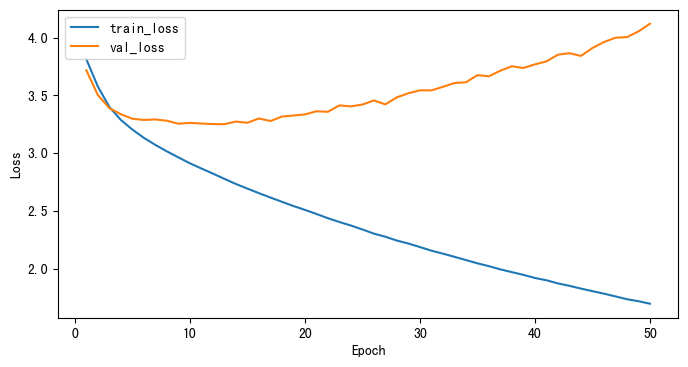

In [35]:
fig, axe = plt.subplots(figsize=(8, 4))
axe.plot(range(1, epochs+1), ls_loss, label='train_loss')
axe.plot(range(1, epochs+1), ls_val_loss, label='val_loss')
axe.legend()

axe.set_xlabel('Epoch')
axe.set_ylabel('Loss')